In [1]:
from ddgs import DDGS
from fastcore.all import *
from fastai.vision.widgets import *
from fastdownload import download_url
from PIL import Image
from pathlib import Path
import requests
import os
from fastai.vision.all import *


## Gromadzenie danych

In [2]:
def search_images(term, max_images=150):
    print(f"Searching '{term}'...")
    with DDGS() as ddgs:
        results = ddgs.images(term, max_results=max_images)
        image_urls = [r['image'] for r in results]
    return L(image_urls)

In [3]:
search_images

<function __main__.search_images(term, max_images=150)>

In [4]:
ims = search_images('plane')
len(ims)

Searching 'plane'...


100

In [ ]:
ims = ['https://t3.ftcdn.net/jpg/00/01/47/28/360_F_1472821_kMjcU0El8NkcU0k7zNtlVTU0Fl8W2l.jpg']

In [6]:
dest = 'images/plane.jpg'
download_url(ims[0], dest)

Path('images/plane.jpg')

In [7]:
im = Image.open(dest)
im.thumbnail((128,128))
im.show()

In [8]:
transport_types = 'ship', 'plane', 'train', 'bus'
path = Path('transport')

In [ ]:
for o in transport_types:
    dest = path / o
    dest.mkdir(exist_ok=True, parents=True)


    with DDGS() as ddgs:
        results = ddgs.images(f'{o}', max_results=150)
        urls = [r['image'] for r in results]


    for i, url in enumerate(urls):
        img_path = dest / f"{o}_{i}.jpg"
        try:
            resp = requests.get(url, timeout=10)
            resp.raise_for_status() 
            with open(img_path, 'wb') as f:
                f.write(resp.content)
            print(f"Downloaded: {img_path}")
        except Exception as e:
            print(f"Cannot download: {url}, error: {e}")

Downloaded: transport/ship/ship_0.jpg
Downloaded: transport/ship/ship_1.jpg
Downloaded: transport/ship/ship_2.jpg
Downloaded: transport/ship/ship_3.jpg
Downloaded: transport/ship/ship_4.jpg
Downloaded: transport/ship/ship_5.jpg
Downloaded: transport/ship/ship_6.jpg
Downloaded: transport/ship/ship_7.jpg
Downloaded: transport/ship/ship_8.jpg
Downloaded: transport/ship/ship_9.jpg
Downloaded: transport/ship/ship_10.jpg
Downloaded: transport/ship/ship_11.jpg
Downloaded: transport/ship/ship_12.jpg
Downloaded: transport/ship/ship_13.jpg
Downloaded: transport/ship/ship_14.jpg
Downloaded: transport/ship/ship_15.jpg
Downloaded: transport/ship/ship_16.jpg
Downloaded: transport/ship/ship_17.jpg
Downloaded: transport/ship/ship_18.jpg
Downloaded: transport/ship/ship_19.jpg
Downloaded: transport/ship/ship_20.jpg
Downloaded: transport/ship/ship_21.jpg
Downloaded: transport/ship/ship_22.jpg
Downloaded: transport/ship/ship_23.jpg
Downloaded: transport/ship/ship_24.jpg
Downloaded: transport/ship/ship_25.

In [10]:
fns = get_image_files(path)
fns

(#346) [Path('transport/bus/bus_31.jpg'),Path('transport/bus/bus_25.jpg'),Path('transport/bus/bus_19.jpg'),Path('transport/bus/bus_18.jpg'),Path('transport/bus/bus_24.jpg'),Path('transport/bus/bus_8.jpg'),Path('transport/bus/bus_32.jpg'),Path('transport/bus/bus_33.jpg'),Path('transport/bus/bus_27.jpg'),Path('transport/bus/bus_23.jpg'),Path('transport/bus/bus_37.jpg'),Path('transport/bus/bus_22.jpg'),Path('transport/bus/bus_34.jpg'),Path('transport/bus/bus_20.jpg'),Path('transport/bus/bus_21.jpg'),Path('transport/bus/bus_35.jpg'),Path('transport/bus/bus_85.jpg'),Path('transport/bus/bus_52.jpg'),Path('transport/bus/bus_46.jpg'),Path('transport/bus/bus_47.jpg')...]

In [11]:
failed = verify_images(fns)
failed

(#4) [Path('transport/bus/bus_52.jpg'),Path('transport/bus/bus_81.jpg'),Path('transport/bus/bus_70.jpg'),Path('transport/bus/bus_77.jpg')]

In [12]:
failed.map(Path.unlink);

## Od danych do obiektu DataLoaders

In [13]:
transport = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [14]:
dls = transport.dataloaders(path)

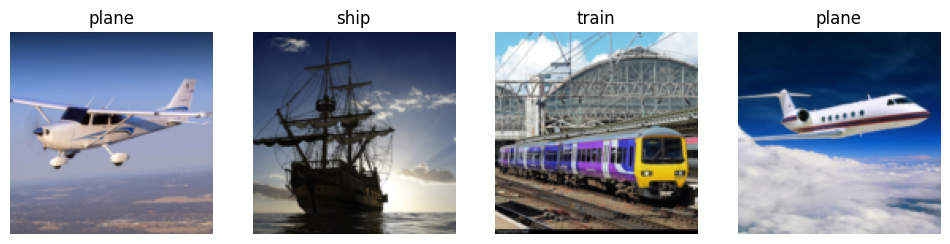

In [15]:
dls.valid.show_batch(max_n=4, nrows=1)

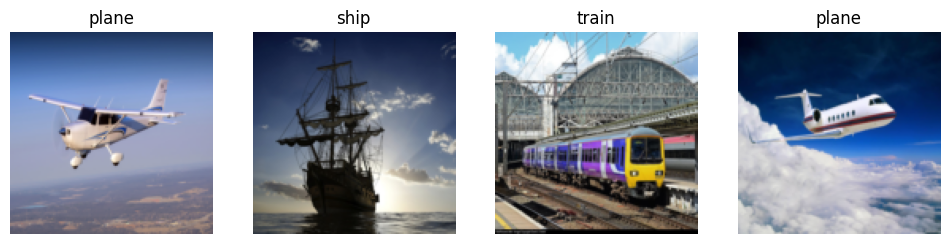

In [16]:
transport = transport.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = transport.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

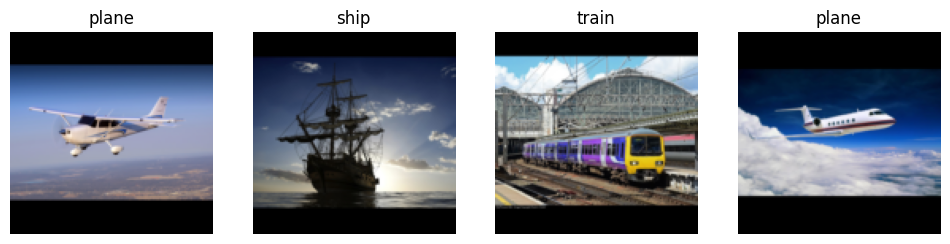

In [17]:
transport = transport.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = transport.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

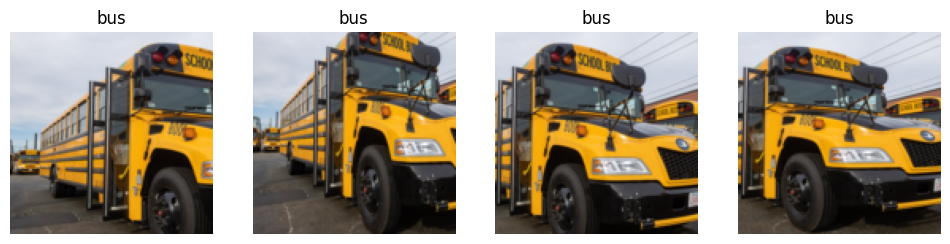

In [18]:
transport = transport.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = transport.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

### Generowanie sztucznych danych

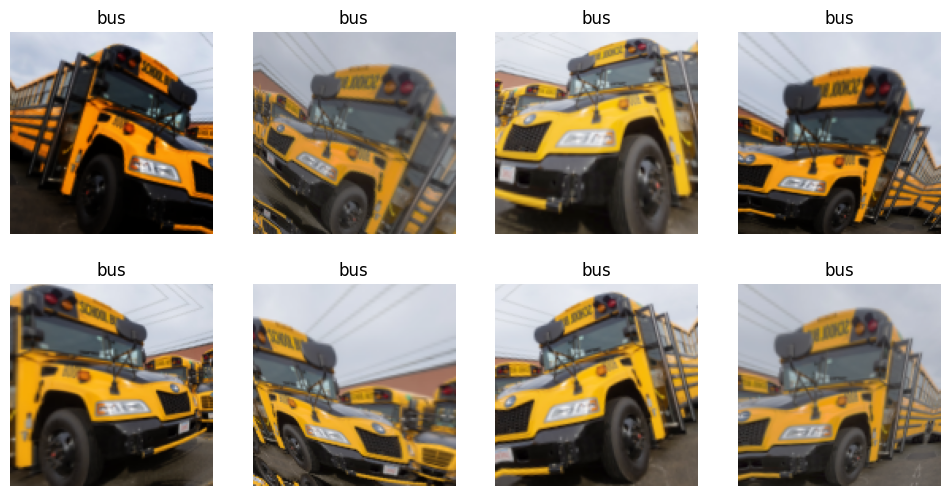

In [19]:
transport = transport.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = transport.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

## Trenowanie modelu i używanie go do czyszczenia danych

In [20]:
transport = transport.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = transport.dataloaders(path)

In [21]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

/Users/fabian/Pliki/programowanie/Projekty własne/środki komunikacji ai/.venv/lib/python3.13/site-packages/fastai/vision/learner.py:303: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


epoch,train_loss,valid_loss,error_rate,time
0,1.998239,0.519049,0.176471,00:06


epoch,train_loss,valid_loss,error_rate,time
0,0.549167,0.201877,0.058824,00:05
1,0.391654,0.166905,0.058824,00:05
2,0.316623,0.129876,0.058824,00:05
3,0.250093,0.112493,0.044118,00:05


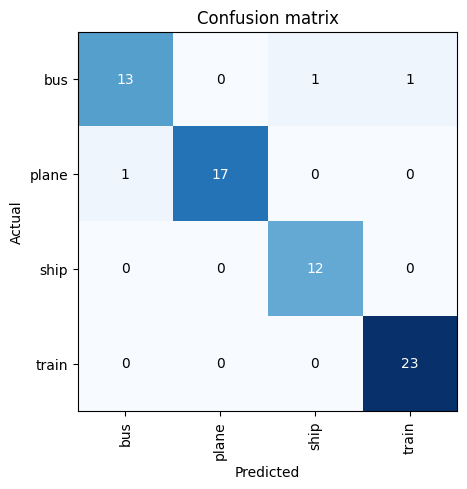

In [22]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

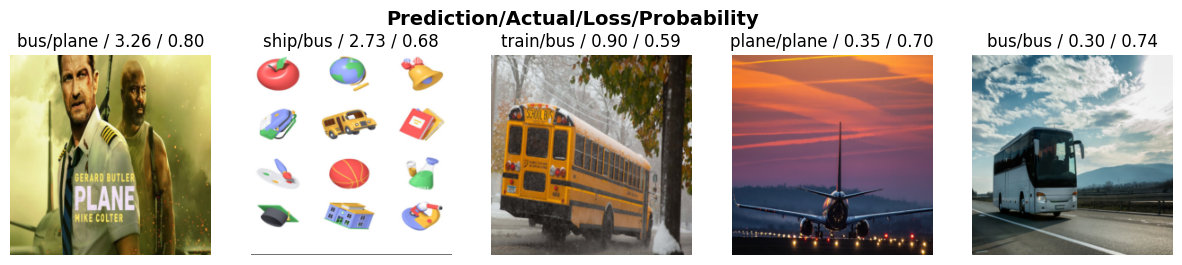

In [23]:
interp.plot_top_losses(5, nrows=1)

In [24]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [ ]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

### Korzystanie z modelu do wnioskowania

In [26]:
learn.export()

In [27]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [28]:
learn_inf = load_learner(path/'export.pkl')

/Users/fabian/Pliki/programowanie/Projekty własne/środki komunikacji ai/.venv/lib/python3.13/site-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


In [29]:
learn_inf.predict('images/plane.jpg')

('plane', tensor(1), tensor([3.0877e-08, 1.0000e+00, 1.2783e-08, 3.7718e-08]))

In [30]:
learn_inf.dls.vocab

['bus', 'plane', 'ship', 'train']

### Tworzenie w notatniku aplikacji na podstawie modelu

In [31]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value=(), description='Upload')

In [ ]:
btn_upload = SimpleNamespace(data = ['images/plane.jpg'])

In [33]:
img = PILImage.create(btn_upload.data[-1])

In [ ]:
img = PILImage.create(bytes(btn_upload.value[0]['content']))

AttributeError: 'types.SimpleNamespace' object has no attribute 'value'

In [35]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [36]:
pred,pred_idx,probs = learn_inf.predict(img)

In [37]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: plane; Probability: 1.0000')

In [42]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [43]:
def on_click_classify(change):
    img = PILImage.create(bytes(btn_upload.value[0]['content']))
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [ ]:
btn_upload = widgets.FileUpload()

In [45]:
VBox([widgets.Label('Choose your photo:'), 
      btn_upload, btn_run, out_pl, lbl_pred])